
# Uber Fare Prediction — Cleaned Practical Notebook

**Tasks covered:**  
1. Pre-process the dataset (datetime parsing, dtype fixes).  
2. Identify outliers (IQR method) and optionally remove them.  
3. Check correlations between features and target.  
4. Implement Linear Regression and Random Forest Regression.  
5. Evaluate models (R², RMSE, MAE) and compare results.

**Notes:** This notebook expects a CSV file called `uber.csv` in the same folder. If your dataset has a different name, update the `DATA_PATH` variable below.


In [1]:

# Basic imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "uber.csv"  


In [2]:

# Load data (adjust path if needed)
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
df.head()


Loaded: uber.csv
Shape: (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:

# Inspect columns and basic info
print(df.columns.tolist())
display(df.info())
display(df.describe(include='all').T)


['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,200000.0,NaN,NaN,NaN,27712503.68235,16013822.212829,1.0,13825346.25,27745495.0,41555300.75,55423567.0
key,200000,200000,2009-08-29 02:36:56.0000003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare_amount,200000.0,NaN,NaN,NaN,11.359955,9.901776,-52.0,6.0,8.5,12.5,499.0
pickup_datetime,200000,196629,2009-02-12 12:46:00 UTC,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_longitude,200000.0,NaN,NaN,NaN,-72.527638,11.437787,-1340.64841,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,200000.0,NaN,NaN,NaN,39.935885,7.720539,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,NaN,NaN,NaN,-72.525292,13.117408,-3356.6663,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,NaN,NaN,NaN,39.92389,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,200000.0,NaN,NaN,NaN,1.684535,1.385997,0.0,1.0,1.0,2.0,208.0


In [4]:

# Drop obvious useless columns if present (adjust to your dataset)
for col in ['Unnamed: 0', 'key']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)
print("After dropping cols, shape:", df.shape)


After dropping cols, shape: (200000, 7)


In [5]:

# Parse pickup_datetime to datetime and extract month & hour as integer types
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['month'] = df['pickup_datetime'].dt.month.astype('Int64')
    df['hour'] = df['pickup_datetime'].dt.hour.astype('Int64')
    # drop original if not needed
    df.drop(columns=['pickup_datetime'], inplace=True)
else:
    print("No pickup_datetime column found; ensure your timestamp column is named 'pickup_datetime'")


In [6]:

# Ensure numeric columns are numeric (coerce errors -> NaN)
num_cols = ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
# Show dtypes
df.dtypes


fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
month                  Int64
hour                   Int64
dtype: object

In [7]:

# Single, vectorized haversine distance function
def haversine_vectorized(lon1, lat1, lon2, lat2):
    # convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, (lon1, lat1, lon2, lat2))
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Add distance column if coordinates present
coord_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
if all(col in df.columns for col in coord_cols):
    df['distance_km'] = haversine_vectorized(df['pickup_longitude'].values,
                                            df['pickup_latitude'].values,
                                            df['dropoff_longitude'].values,
                                            df['dropoff_latitude'].values)
    print("Added distance_km column.")
else:
    print("Coordinate columns missing; distance not computed.")


Added distance_km column.


In [8]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,month,hour,distance_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,5,19,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,7,20,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,8,21,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,6,8,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,8,17,4.475450


In [9]:

# Handle missing or suspicious values
# passenger_count: replace 0 or very large numbers with median of realistic values (1..6)
if 'passenger_count' in df.columns:
    med_pc = df.loc[df['passenger_count'].between(1,6),'passenger_count'].median()
    df['passenger_count'] = df['passenger_count'].apply(lambda x: med_pc if pd.isna(x) or x==0 or x>6 else x)

# fare_amount: replace non-positive fares with median positive fare
if 'fare_amount' in df.columns:
    med_fare = df.loc[df['fare_amount']>0,'fare_amount'].median()
    df['fare_amount'] = df['fare_amount'].apply(lambda x: med_fare if pd.isna(x) or x<=0 else x)

# Drop rows with essential NaNs (e.g., coordinates or fare)
essential_cols = ['fare_amount','distance_km']
for c in essential_cols:
    if c in df.columns:
        df = df[~df[c].isna()]

print("After cleaning, shape:", df.shape)


After cleaning, shape: (199999, 9)


In [10]:

# Outlier detection using IQR for numeric columns of interest
def remove_outliers_iqr(df, cols, k=1.5):
    df_out = df.copy()
    for col in cols:
        if col in df_out.columns:
            Q1 = df_out[col].quantile(0.25)
            Q3 = df_out[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - k * IQR
            upper = Q3 + k * IQR
            # keep only rows within bounds
            df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    return df_out

numeric_check_cols = [c for c in ['fare_amount','distance_km','passenger_count','hour','month'] if c in df.columns]
print("Numeric cols checked for outliers:", numeric_check_cols)
df_no_out = remove_outliers_iqr(df, numeric_check_cols, k=1.5)
print("Shape before outlier removal:", df.shape, "after:", df_no_out.shape)
# You can switch to df = df_no_out if you want to remove outliers permanently
# df = df_no_out


Numeric cols checked for outliers: ['fare_amount', 'distance_km', 'passenger_count', 'hour', 'month']
Shape before outlier removal: (199999, 9) after: (154876, 9)


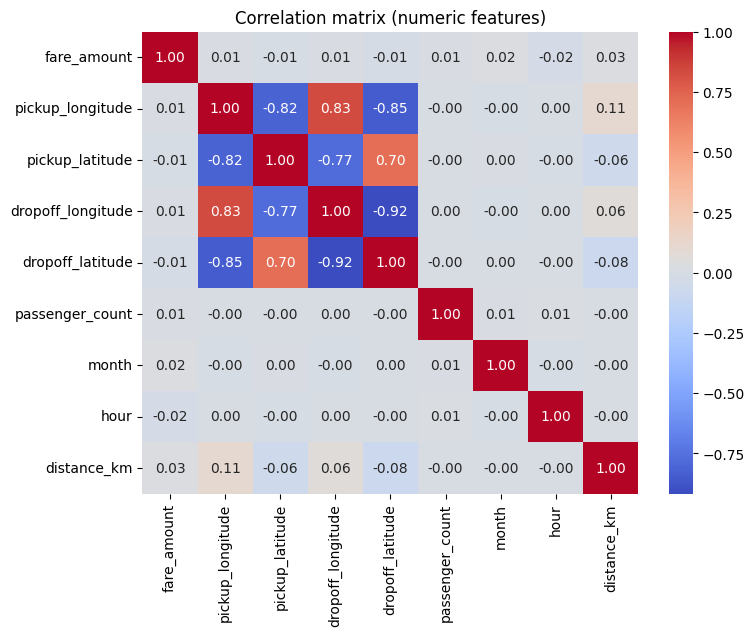

In [11]:

# Correlation heatmap (using numeric columns)
plt.figure(figsize=(8,6))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (numeric features)')
plt.show()


In [12]:

# Prepare features and target
# Choose a reasonable set of features
features = []
for c in ['distance_km','passenger_count','hour','month','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    if c in df.columns:
        features.append(c)
print("Using features:", features)

X = df[features].copy()
y = df['fare_amount'].copy()

# Fill any remaining NaNs in X with median
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print("Train/Test sizes:", X_train.shape, X_test.shape)


Using features: ['distance_km', 'passenger_count', 'hour', 'month', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
Train/Test sizes: (169999, 8) (30000, 8)


In [13]:

# Scale numeric features (important for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("Linear Regression — R2: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(r2_lr, rmse_lr, mae_lr))


Linear Regression — R2: 0.0014, RMSE: 10.1510, MAE: 6.0296


In [15]:

# Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)  # tree-based models don't require scaled features
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest — R2: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(r2_rf, rmse_rf, mae_rf))


Random Forest — R2: 0.6844, RMSE: 5.7063, MAE: 2.2415


In [16]:

# Comparison table
results = pd.DataFrame({
    'model': ['LinearRegression','RandomForest'],
    'r2': [r2_lr, r2_rf],
    'rmse': [rmse_lr, rmse_rf],
    'mae': [mae_lr, mae_rf]
})
display(results)


,model,r2,rmse,mae
0,LinearRegression,0.001426,10.150997,6.029589
1,RandomForest,0.684446,5.706311,2.241502
